In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import time
import os
import sys
from tqdm import tqdm
import shutil
import pyarrow.parquet as pq
import pyarrow as pa
from uuid import uuid4
import warnings
import subprocess
warnings.filterwarnings('ignore')

# Enhanced PyTorch and CUDA diagnostics
def check_cuda_environment():
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available. This notebook requires a GPU.")
    
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    
    # Test CUDA operation
    try:
        test_tensor = torch.tensor([1.0, 2.0, 3.0], device='cuda')
        test_result = test_tensor + 1
        print(f"CUDA test operation successful: {test_result}")
    except Exception as e:
        print(f"CUDA test operation failed: {e}")
        raise
    
    # Check NVIDIA driver and CUDA toolkit
    try:
        nvidia_smi = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        print("NVIDIA-SMI output:")
        print(nvidia_smi.stdout)
    except Exception as e:
        print(f"Failed to run nvidia-smi: {e}")
    
    # Check GPU memory
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 2**30:.2f} GiB")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(0) / 2**30:.2f} GiB")
    print(f"Reserved GPU memory: {torch.cuda.memory_reserved(0) / 2**30:.2f} GiB")

try:
    check_cuda_environment()
except Exception as e:
    print(f"Error with PyTorch or CUDA setup: {e}")
    print("Try reinstalling PyTorch: pip install torch==2.7.0 --index-url https://download.pytorch.org/whl/cu124")
    raise

# Environment diagnostics
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print(f"PATH: {os.environ.get('PATH')}")
print(f"Available disk space: {shutil.disk_usage('/').free / (2**30):.2f} GiB")

# Check for module shadowing
if os.path.exists('/workspace/XAI/torch.py') or os.path.exists('/workspace/XAI/torch.pyc'):
    print("Warning: Found 'torch.py' or 'torch.pyc' in /workspace/XAI. Please rename or remove it.")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (GPU only)
device = torch.device("cuda")
print(f"Using device: {device}")

# Clear GPU memory
torch.cuda.empty_cache()
print("Cleared GPU memory cache")

PyTorch version: 2.2.2+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA RTX A6000
GPU count: 1
Current device: 0
CUDA test operation successful: tensor([2., 3., 4.], device='cuda:0')
NVIDIA-SMI output:
Sun May 11 17:28:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:56:00.0 Off |                    0 |
| 30%   32C   

In [2]:
def load_data(data_dir="/workspace/data", file_name="merged_data.csv"):
    file_path = os.path.join(data_dir, file_name)
    alt_path = "/workspace/XAI-1/Predict Future Sales/merged_data.csv"
    
    if not os.path.exists(file_path):
        if os.path.exists(alt_path):
            file_path = alt_path
        else:
            raise FileNotFoundError(f"File not found at {file_path} or {alt_path}")
    
    try:
        data = pd.read_csv(file_path)
        print(f"Loaded data from {file_path}")
        print(f"Dataset shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_path}: {e}")
    
    # Verify expected columns
    expected_columns = ['date', 'shop_id', 'item_id', 'item_name', 'item_cnt_day', 'item_price', 'item_category_id', 'shop_name', 'item_category_name', 'date_block_num']
    missing_cols = [col for col in expected_columns if col not in data.columns]
    if missing_cols:
        print(f"Warning: Missing expected columns: {missing_cols}")
    
    return data

# Load data
data = load_data()

Loaded data from /workspace/XAI-1/Predict Future Sales/merged_data.csv
Dataset shape: (2935849, 10)
Columns: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']


In [25]:
import pandas as pd
import polars as pl
import numpy as np
import time
import os
from sklearn.preprocessing import RobustScaler
import pickle
import logging
import psutil

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('/workspace/processed_data/preprocess.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def log_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / (1024 ** 3):.2f} GB")

def load_data(data_dir="/workspace/data", file_name="merged_data.csv"):
    file_path = os.path.join(data_dir, file_name)
    alt_path = "/workspace/XAI-1/Predict Future Sales/merged_data.csv"
    
    if not os.path.exists(file_path):
        if os.path.exists(alt_path):
            file_path = alt_path
        else:
            raise FileNotFoundError(f"File not found at {file_path} or {alt_path}")
    
    try:
        data = pd.read_csv(file_path)
        logger.info(f"Loaded data from {file_path}")
        logger.info(f"Dataset shape: {data.shape}")
        logger.info(f"Columns: {list(data.columns)}")
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_path}: {e}")
    
    # Verify expected columns
    expected_columns = ['date', 'shop_id', 'item_id', 'item_name', 'item_cnt_day', 'item_price', 'item_category_id', 'shop_name', 'item_category_name', 'date_block_num']
    missing_cols = [col for col in expected_columns if col not in data.columns]
    if missing_cols:
        logger.warning(f"Missing expected columns: {missing_cols}")
    
    return data

def preprocess_data(data):
    start_time = time.time()
    
    # Convert to polars DataFrame
    df = pl.from_pandas(data)
    log_memory_usage()
    
    # Validate input data
    logger.info(f"Initial dataset size: {len(df)}")
    logger.info(f"Unique shops: {df['shop_id'].n_unique()}")
    logger.info(f"Unique items: {df['item_id'].n_unique()}")
    logger.info(f"Unique date_block_num: {df['date_block_num'].n_unique()}")
    logger.info(f"date_block_num range: {df['date_block_num'].min()} to {df['date_block_num'].max()}")
    
    # Check for duplicates
    duplicates = df.group_by(['date_block_num', 'shop_id', 'item_id']).agg(count=pl.count()).filter(pl.col('count') > 1)
    if duplicates.height > 0:
        logger.warning(f"Found {duplicates.height} duplicate shop-item-date combinations. Inspecting duplicates...")
        logger.info(f"Duplicate counts sample:\n{duplicates.head(5).to_pandas().to_string()}")
        df = df.group_by(['date_block_num', 'shop_id', 'item_id', 'item_category_id']).agg(
            item_cnt_day=pl.col('item_cnt_day').sum(),
            item_price=pl.col('item_price').mean()
        )
        logger.info(f"Dataset size after duplicate removal: {len(df)}")
    
    # Filter to date_block_num <= 32
    if df['date_block_num'].max() > 32:
        logger.info("Filtering to date_block_num <= 32 to align with paper (Jan 2013–Oct 2015)")
        df = df.filter(pl.col('date_block_num') <= 32)
        logger.info(f"Dataset size after filtering date_block_num <= 32: {len(df)}")
    
    # Filter to 54 shops based on activity
    shop_activity = df.group_by('shop_id').agg(total_sales=pl.col('item_cnt_day').sum())
    top_shops = shop_activity.sort('total_sales', descending=True).head(54)['shop_id'].to_list()
    logger.info(f"Selected top 54 shops: {top_shops}")
    df = df.filter(pl.col('shop_id').is_in(top_shops))
    logger.info(f"Dataset size after filtering to 54 shops: {len(df)}")
    logger.info(f"Unique shops after filtering: {df['shop_id'].n_unique()}")
    log_memory_usage()
    
    # Early column dropping
    keep_cols = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'item_cnt_day', 'item_price']
    df = df.select(keep_cols)
    logger.info(f"Initial columns kept: {df.columns}")
    
    # Optimize dtypes
    df = df.with_columns([
        pl.col('date_block_num').cast(pl.Int16),
        pl.col('shop_id').cast(pl.Int32),
        pl.col('item_id').cast(pl.Int32),
        pl.col('item_category_id').cast(pl.Int32),
        pl.col('item_cnt_day').cast(pl.Float32),
        pl.col('item_price').cast(pl.Float32)
    ])
    
    # Winsorization
    step_time = time.time()
    quantile_99 = df['item_cnt_day'].quantile(0.99)
    logger.info(f"99th percentile for item_cnt_day: {quantile_99:.2f}")
    df = df.with_columns(
        item_cnt_day_winsor=pl.col('item_cnt_day').clip(None, quantile_99)
    )
    outlier_count = df.filter(pl.col('item_cnt_day') > quantile_99).height
    logger.info(f"Outliers capped: {outlier_count} ({(outlier_count / len(df) * 100):.2f}%)")
    logger.info(f"Winsorization time: {time.time() - step_time:.2f} seconds")
    
    # Handle negative sales
    step_time = time.time()
    df = df.with_columns([
        pl.when(pl.col('item_cnt_day_winsor') < 0)
         .then(pl.col('item_cnt_day_winsor').abs())
         .otherwise(0)
         .alias('returns'),
        pl.col('item_cnt_day_winsor').clip(lower_bound=0).alias('item_cnt_day_winsor')
    ])
    logger.info(f"Negative sales after processing: {df.filter(pl.col('item_cnt_day_winsor') < 0).height}")
    logger.info(f"Negative sales handling time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Aggregate to monthly level before grid creation
    step_time = time.time()
    df = df.group_by(['date_block_num', 'shop_id', 'item_id', 'item_category_id']).agg([
        pl.col('item_cnt_day_winsor').sum().alias('item_cnt_day_winsor'),
        pl.col('returns').sum().alias('returns'),
        pl.col('item_price').mean().alias('item_price')
    ]).with_columns([
        ((pl.col('date_block_num') % 12) + 1).cast(pl.Int32).alias('month'),
        ((pl.col('date_block_num') // 12) + 2013).cast(pl.Int32).alias('year')
    ])
    logger.info(f"Dataset size after aggregation: {len(df)}")
    logger.info(f"Unique shops after aggregation: {df['shop_id'].n_unique()}")
    logger.info(f"Unique items after aggregation: {df['item_id'].n_unique()}")
    logger.info(f"Unique date_block_num after aggregation: {df['date_block_num'].n_unique()}")
    logger.info(f"Aggregation time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Create full shop-item-month grid
    step_time = time.time()
    shops = df['shop_id'].unique().to_list()
    items = df['item_id'].unique().to_list()
    date_blocks = list(range(33))  # 0–32
    shops_df = pl.DataFrame({'shop_id': shops})
    items_df = pl.DataFrame({'item_id': items})
    date_blocks_df = pl.DataFrame({'date_block_num': date_blocks})
    grid = shops_df.join(items_df, how='cross').join(date_blocks_df, how='cross').with_columns([
        pl.col('shop_id').cast(pl.Int32),
        pl.col('item_id').cast(pl.Int32),
        pl.col('date_block_num').cast(pl.Int16)
    ])
    logger.info(f"Full grid size: {len(grid)}")
    
    # Merge with aggregated data
    df = grid.join(
        df,
        on=['shop_id', 'item_id', 'date_block_num'],
        how='left'
    ).with_columns([
        pl.col('item_cnt_day_winsor').fill_null(0),
        pl.col('returns').fill_null(0),
        pl.col('item_price').fill_null(
            pl.col('item_price').mean().over('item_id')
        ).fill_null(0),
        pl.col('item_category_id').fill_null(
            pl.col('item_category_id').first().over('item_id')
        ).fill_null(0),
        pl.col('month').fill_null(
            ((pl.col('date_block_num') % 12) + 1).cast(pl.Int32)
        ),
        pl.col('year').fill_null(
            ((pl.col('date_block_num') // 12) + 2013).cast(pl.Int32)
        )
    ]).with_columns(
        pl.datetime(pl.col('year'), pl.col('month'), 1).alias('date')
    )
    logger.info(f"Dataset size after grid merge: {len(df)}")
    logger.info(f"Unique shops after grid: {df['shop_id'].n_unique()}")
    logger.info(f"Unique items after grid: {df['item_id'].n_unique()}")
    logger.info(f"Unique date_block_num after grid: {df['date_block_num'].n_unique()}")
    logger.info(f"Grid creation and merge time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Exclude products with significant sales activity
    step_time = time.time()
    shop_item_non_zero = df.group_by(['shop_id', 'item_id']).agg(
        non_zero_months=pl.col('item_cnt_day_winsor').ne(0).sum(),
        total_sales=pl.col('item_cnt_day_winsor').sum()
    )
    valid_shop_items = shop_item_non_zero.filter(
        (pl.col('non_zero_months') >= 4) & (pl.col('total_sales') >= 8)
    ).select(['shop_id', 'item_id'])
    initial_size = len(df)
    df = df.join(valid_shop_items, on=['shop_id', 'item_id'], how='inner')
    logger.info(f"Records dropped due to insufficient sales: {initial_size - len(df)}")
    logger.info(f"Records after excluding sparse products: {len(df)}")
    logger.info(f"Valid shop-item pairs: {len(valid_shop_items)}")
    logger.info(f"Product exclusion time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Create lag features
    def create_lag_features(df):
        df = df.sort(['shop_id', 'item_id', 'date'])
        for lag in [1, 2, 3]:
            df = df.with_columns([
                pl.col('item_cnt_day_winsor').shift(lag).over(['shop_id', 'item_id']).alias(f'lag_sales_{lag}'),
                pl.col('returns').shift(lag).over(['shop_id', 'item_id']).alias(f'lag_returns_{lag}'),
                pl.col('item_price').shift(lag).over(['shop_id', 'item_id']).alias(f'lag_price_{lag}')
            ])
        return df
    
    step_time = time.time()
    try:
        df = create_lag_features(df)
    except Exception as e:
        logger.error(f"Error in lag feature creation: {e}")
        raise
    logger.info(f"Lag feature creation time: {time.time() - step_time:.2f} seconds")
    
    # Interpolate missing lag features
    numerical_cols = [
        'item_cnt_day_winsor', 'returns', 'item_price',
        'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
        'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
        'lag_price_1', 'lag_price_2', 'lag_price_3'
    ]
    step_time = time.time()
    logger.info("\nMissing values in numerical columns before interpolation:")
    logger.info(df.select(numerical_cols).null_count().to_pandas().to_string())
    df = df.with_columns([
        pl.col(col).interpolate().over(['shop_id', 'item_id']).fill_null(0)
        for col in numerical_cols
    ])
    logger.info("\nMissing values in numerical columns after interpolation:")
    logger.info(df.select(numerical_cols).null_count().to_pandas().to_string())
    logger.info(f"Records after interpolation: {len(df)}")
    logger.info(f"Interpolation time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Convert to pandas for scaling and saving
    monthly_sales = df.to_pandas()
    del df  # Free memory
    log_memory_usage()
    
    # Save unscaled data for debugging
    step_time = time.time()
    monthly_sales.to_parquet('/workspace/processed_data/monthly_sales_unscaled.parquet')
    logger.info("Saved unscaled data to /workspace/processed_data/monthly_sales_unscaled.parquet")
    logger.info(f"Unscaled data save time: {time.time() - step_time:.2f} seconds")
    
    # Robust scaling
    step_time = time.time()
    scaler = RobustScaler()
    try:
        train_data = monthly_sales[monthly_sales['date_block_num'] < 31][numerical_cols]
        logger.info(f"Training data shape for scaler fit: {train_data.shape}")
        logger.info("Pre-scaling training data stats:")
        for col in numerical_cols:
            mean = train_data[col].mean()
            std = train_data[col].std()
            logger.info(f"  {col}: mean={mean:.6f}, std={std:.6f}")
        scaler.fit(train_data)
        logger.info(f"Scaler center: {scaler.center_}")
        logger.info(f"Scaler scale: {scaler.scale_}")
        scaled_data = scaler.transform(monthly_sales[numerical_cols])
        monthly_sales.loc[:, numerical_cols] = scaled_data
        logger.info("Post-scaling numerical means:")
        for col in numerical_cols:
            mean = monthly_sales[col].mean()
            std = monthly_sales[col].std()
            logger.info(f"  {col}: mean={mean:.6f}, std={std:.6f}")
        if monthly_sales[numerical_cols].isna().any().any():
            raise ValueError("NaN values introduced during scaling.")
        with open('/workspace/processed_data/scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    except Exception as e:
        logger.error(f"Error in scaling: {e}")
        raise
    logger.info(f"Robust scaling time: {time.time() - step_time:.2f} seconds")
    log_memory_usage()
    
    # Keep only necessary columns
    step_time = time.time()
    keep_cols = numerical_cols + ['shop_id', 'item_id', 'item_category_id', 'date', 'date_block_num']
    monthly_sales = monthly_sales[keep_cols]
    logger.info(f"Features after preprocessing: {len(monthly_sales.columns)}")
    
    # Check for duplicate columns
    duplicate_cols = monthly_sales.columns[monthly_sales.columns.duplicated()].tolist()
    if duplicate_cols:
        logger.warning(f"Duplicate columns found: {duplicate_cols}. Removing duplicates...")
        monthly_sales = monthly_sales.loc[:, ~monthly_sales.columns.duplicated()]
        logger.info(f"Features after removing duplicates: {len(monthly_sales.columns)}")
    
    # Optimize final dtypes
    monthly_sales = monthly_sales.astype({
        'item_cnt_day_winsor': 'float32', 'returns': 'float32', 'item_price': 'float32',
        'lag_sales_1': 'float32', 'lag_sales_2': 'float32', 'lag_sales_3': 'float32',
        'lag_returns_1': 'float32', 'lag_returns_2': 'float32', 'lag_returns_3': 'float32',
        'lag_price_1': 'float32', 'lag_price_2': 'float32', 'lag_price_3': 'float32',
        'shop_id': 'int32', 'item_id': 'int32', 'item_category_id': 'int32',
        'date_block_num': 'int16'
    }, errors='ignore')
    logger.info(f"Final column selection and dtype optimization time: {time.time() - step_time:.2f} seconds")
    
    # Final validation
    logger.info(f"Final dataset size: {len(monthly_sales)}")
    logger.info(f"Unique shops: {monthly_sales['shop_id'].nunique()}")
    logger.info(f"Unique items: {monthly_sales['item_id'].nunique()}")
    logger.info(f"Unique date_block_num: {monthly_sales['date_block_num'].nunique()}")
    expected_size = 2775000
    if abs(len(monthly_sales) - expected_size) / expected_size > 0.1:
        logger.warning(f"Final dataset size {len(monthly_sales)} deviates significantly from expected {expected_size}. "
                       "Verify input data and preprocessing steps.")
    
    logger.info(f"Total preprocessing time: {time.time() - start_time:.2f} seconds")
    log_memory_usage()
    return monthly_sales

if __name__ == '__main__':
    # Load data using the provided function
    data = load_data()
    monthly_sales = preprocess_data(data)
    monthly_sales.to_parquet('/workspace/raw_data/processed_sales.parquet')

2025-05-11 19:23:36 - INFO - Loaded data from /workspace/XAI-1/Predict Future Sales/merged_data.csv
2025-05-11 19:23:36 - INFO - Dataset shape: (2935849, 10)
2025-05-11 19:23:36 - INFO - Columns: ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name', 'shop_name']
2025-05-11 19:23:37 - INFO - Memory usage: 18.50 GB
2025-05-11 19:23:37 - INFO - Initial dataset size: 2935849
2025-05-11 19:23:37 - INFO - Unique shops: 60
2025-05-11 19:23:37 - INFO - Unique items: 21807
2025-05-11 19:23:37 - INFO - Unique date_block_num: 34
2025-05-11 19:23:37 - INFO - date_block_num range: 0 to 33
2025-05-11 19:23:37 - WARNING - Found 532228 duplicate shop-item-date combinations. Inspecting duplicates...
2025-05-11 19:23:37 - INFO - Duplicate counts sample:
   date_block_num  shop_id  item_id  count
0               3       28     8019      3
1               0       50    13854      2
2               8       37    11812      3
3 

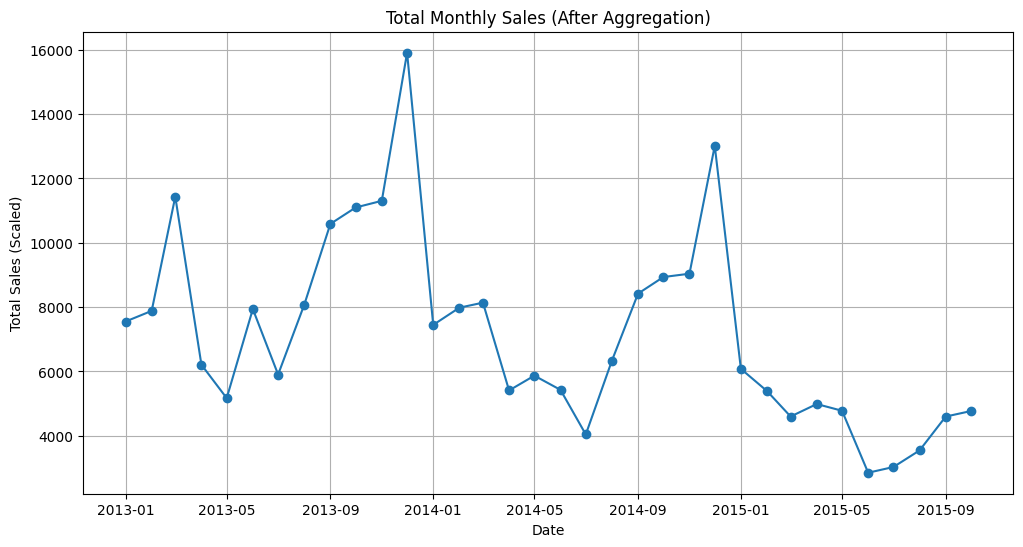

In [ ]:
monthly_totals = monthly_sales.groupby('date')['item_cnt_day_winsor'].sum()
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals.index, monthly_totals.values, marker='o')
plt.title('Total Monthly Sales (After Aggregation)')
plt.xlabel('Date')
plt.ylabel('Total Sales (Scaled)')
plt.grid(True)
plt.show()
plt.close()


In [15]:

import pandas as pd
import polars as pl
import os
from pathlib import Path
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('split.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def split_dataset(data, val_months=2, test_months=1):
    """Split dataset into train/val/test sets and return splits."""
    try:
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Input data must be a pandas DataFrame")
            
        logger.info("Starting data splitting")
        
        # Check required columns
        expected_cols = [
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3',
            'shop_id', 'item_id', 'item_category_id', 'date_block_num'
        ]
        missing_cols = [col for col in expected_cols if col not in data.columns]
        if missing_cols:
            logger.error(f"Missing columns in data: {missing_cols}")
            raise ValueError(f"Missing columns in data: {missing_cols}")
        
        # Convert to polars DataFrame
        df = pl.from_pandas(data)
        
        # Ensure date_block_num <= 32
        df = df.filter(pl.col('date_block_num') <= 32)
        max_date_block = df['date_block_num'].max()
        logger.info(f"Max date_block_num: {max_date_block}")
        
        # Calculate split points
        test_start = max_date_block - test_months + 1
        val_start = test_start - val_months
        
        # Split data
        train_df = df.filter(pl.col('date_block_num') < val_start)
        val_df = df.filter((pl.col('date_block_num') >= val_start) & 
                          (pl.col('date_block_num') < test_start))
        test_df = df.filter(pl.col('date_block_num') >= test_start)
        
        # Define feature and target columns
        numerical_cols = [
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3'
        ]
        categorical_cols = ['shop_id', 'item_id', 'item_category_id']
        feature_cols = numerical_cols + categorical_cols + ['date_block_num']
        target_col = 'item_cnt_day_winsor'
        
        # Extract features and targets
        X_train = train_df.select(feature_cols).to_pandas()
        y_train = train_df.select(target_col).to_pandas()[target_col]
        X_val = val_df.select(feature_cols).to_pandas()
        y_val = val_df.select(target_col).to_pandas()[target_col]
        X_test = test_df.select(feature_cols).to_pandas()
        y_test = test_df.select(target_col).to_pandas()[target_col]
        
        # Log statistics
        logger.info(f"Training set size: {len(X_train)} records")
        logger.info(f"Validation set size: {len(X_val)} records") 
        logger.info(f"Test set size: {len(X_test)} records")
        logger.info(f"Training unique shops: {X_train['shop_id'].nunique()}")
        logger.info(f"Validation unique shops: {X_val['shop_id'].nunique()}")
        logger.info(f"Test unique shops: {X_test['shop_id'].nunique()}")
        logger.info(f"Training unique items: {X_train['item_id'].nunique()}")
        logger.info(f"Validation unique items: {X_val['item_id'].nunique()}")
        logger.info(f"Test unique items: {X_test['item_id'].nunique()}")
        logger.info(f"Training target mean: {y_train.mean():.2f}")
        logger.info(f"Validation target mean: {y_val.mean():.2f}")
        logger.info(f"Test target mean: {y_test.mean():.2f}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test
        
    except Exception as e:
        logger.error(f"Error in split_dataset: {str(e)}")
        raise

# Example usage
if __name__ == '__main__':
    # monthly_sales = pd.read_parquet('/workspace/raw_data/processed_sales.parquet')
    try:
        X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(monthly_sales)
        logger.info("Dataset splitting completed successfully")
    except Exception as e:
        logger.error(f"Dataset splitting failed: {str(e)}")
        raise

2025-05-11 18:10:41 - INFO - Starting data splitting
2025-05-11 18:10:41 - INFO - Max date_block_num: 32


2025-05-11 18:10:41 - INFO - Training set size: 12347190 records
2025-05-11 18:10:41 - INFO - Validation set size: 823146 records
2025-05-11 18:10:41 - INFO - Test set size: 411573 records
2025-05-11 18:10:42 - INFO - Training unique shops: 54
2025-05-11 18:10:42 - INFO - Validation unique shops: 54
2025-05-11 18:10:42 - INFO - Test unique shops: 54
2025-05-11 18:10:42 - INFO - Training unique items: 21305
2025-05-11 18:10:42 - INFO - Validation unique items: 21305
2025-05-11 18:10:42 - INFO - Test unique items: 21305
2025-05-11 18:10:42 - INFO - Training target mean: 0.26
2025-05-11 18:10:42 - INFO - Validation target mean: 0.15
2025-05-11 18:10:42 - INFO - Test target mean: 0.15
2025-05-11 18:10:42 - INFO - Dataset splitting completed successfully


In [16]:
import os
import shutil
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import logging
import subprocess

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler('/workspace/processed_data/save.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def save_datasets(X_train, y_train, X_val, y_val, X_test, y_test, output_dir="."):
    logger.info("Starting dataset saving")
    os.makedirs(output_dir, exist_ok=True)
    
    # Check disk space
    total, used, free = shutil.disk_usage('/')
    free_gb = free / (2**30)
    logger.info(f"Available disk space: {free_gb:.2f} GiB")
    if free_gb < 5:
        logger.error("Low disk space. Need >5 GiB.")
        raise ValueError("Low disk space. Need >5 GiB.")
    
    def save_parquet(df, filename, chunk_size=100000):
        try:
            duplicate_cols = df.columns[df.columns.duplicated()].tolist()
            if duplicate_cols:
                logger.error(f"Duplicate columns in {filename}: {duplicate_cols}")
                raise ValueError(f"Duplicate columns in {filename}: {duplicate_cols}")
            filepath = os.path.join(output_dir, filename)
            table = pa.Table.from_pandas(df)
            pq.write_table(table, filepath, compression='zstd', row_group_size=chunk_size)
            # Verify file exists
            if not os.path.exists(filepath):
                logger.error(f"Failed to save {filename}: File does not exist")
                raise OSError(f"Failed to save {filename}: File does not exist")
            # Set permissions
            os.chmod(filepath, 0o666)
            # Verify row count
            written = pd.read_parquet(filepath)
            if written.shape[0] != df.shape[0]:
                logger.error(f"Row count mismatch in {filename}: expected {df.shape[0]}, got {written.shape[0]}")
                raise ValueError(f"Row count mismatch in {filename}: expected {df.shape[0]}, got {written.shape[0]}")
            # Log file size and permissions
            file_size = os.path.getsize(filepath) / (2**20)  # MB
            permissions = oct(os.stat(filepath).st_mode)[-3:]
            logger.info(f"Saved and verified {filename} at {filepath}, size: {file_size:.2f} MB, permissions: {permissions}")
            # Force filesystem sync
            subprocess.run(['sync'], check=True)
            logger.info(f"Filesystem synced for {filename}")
        except Exception as e:
            logger.error(f"Error saving {filename}: {e}")
            raise
    
    # Save datasets
    save_parquet(X_train, 'X_train_processed.parquet')
    save_parquet(y_train.to_frame(), 'y_train_processed.parquet')
    save_parquet(X_val, 'X_val_processed.parquet')
    save_parquet(y_val.to_frame(), 'y_val_processed.parquet')
    save_parquet(X_test, 'X_test_processed.parquet')
    save_parquet(y_test.to_frame(), 'y_test_processed.parquet')
    
    # Create dummy file to trigger VSCode refresh
    dummy_file = os.path.join(output_dir, '.vscode_refresh_trigger')
    with open(dummy_file, 'w') as f:
        f.write('Trigger VSCode refresh')
    os.chmod(dummy_file, 0o666)
    logger.info(f"Created dummy file {dummy_file} to trigger VSCode refresh")
    
    # List files
    logger.info("Listing files in output directory:")
    for f in os.listdir(output_dir):
        if f.endswith('.parquet'):
            file_path = os.path.join(output_dir, f)
            file_size = os.path.getsize(file_path) / (2**20)  # MB
            permissions = oct(os.stat(file_path).st_mode)[-3:]
            logger.info(f"  {f}, size: {file_size:.2f} MB, permissions: {permissions}")
    
    # Verify workspace path
    workspace_path = os.path.abspath('/workspace')
    logger.info(f"Current workspace path: {workspace_path}")
    logger.info("Ensure /workspace/processed_data is in VSCode's workspace")
    
save_datasets(X_train, y_train, X_val, y_val, X_test, y_test)

2025-05-11 18:10:48 - INFO - Starting dataset saving
2025-05-11 18:10:48 - INFO - Available disk space: 16.53 GiB


2025-05-11 18:10:54 - INFO - Saved and verified X_train_processed.parquet at ./X_train_processed.parquet, size: 46.65 MB, permissions: 666
2025-05-11 18:10:54 - INFO - Filesystem synced for X_train_processed.parquet
2025-05-11 18:10:54 - INFO - Saved and verified y_train_processed.parquet at ./y_train_processed.parquet, size: 1.71 MB, permissions: 666
2025-05-11 18:10:54 - INFO - Filesystem synced for y_train_processed.parquet
2025-05-11 18:10:55 - INFO - Saved and verified X_val_processed.parquet at ./X_val_processed.parquet, size: 8.92 MB, permissions: 666
2025-05-11 18:10:55 - INFO - Filesystem synced for X_val_processed.parquet
2025-05-11 18:10:55 - INFO - Saved and verified y_val_processed.parquet at ./y_val_processed.parquet, size: 0.09 MB, permissions: 666
2025-05-11 18:10:55 - INFO - Filesystem synced for y_val_processed.parquet
2025-05-11 18:10:55 - INFO - Saved and verified X_test_processed.parquet at ./X_test_processed.parquet, size: 4.81 MB, permissions: 666
2025-05-11 18:1

In [20]:

import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import polars as pl
from tqdm import tqdm
from pathlib import Path
import os
import logging
import pkg_resources

# Check Polars version
required_polars_version = "0.20.0"
current_polars_version = pkg_resources.get_distribution("polars").version
if pkg_resources.parse_version(current_polars_version) < pkg_resources.parse_version(required_polars_version):
    raise ImportError(
        f"Polars version {current_polars_version} is outdated. Please upgrade to {required_polars_version} or higher "
        "using 'pip install --upgrade polars'"
    )

# Set file descriptor limit
os.system('ulimit -n 4096')

# Minimal logging with DEBUG level for scheduler verification
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# GPU Configuration
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

class SalesDataset(Dataset):
    def __init__(self, X_file, y_file, sequence_length=12, num_shops=54, num_items=22170, num_categories=84):
        logger.info(f"Loading dataset from {X_file}")
        start = time.time()
        
        # Load data
        self.X = pl.read_parquet(X_file)
        self.y = pl.read_parquet(y_file).select(['item_cnt_day_winsor']).to_numpy().flatten().astype(np.float32)
        logger.info(f"Loaded Parquet files in {time.time() - start:.2f}s")
        
        if len(self.X) != len(self.y):
            raise ValueError(f"Mismatch between X ({len(self.X)}) and y ({len(self.y)}) rows")
        
        self.sequence_length = sequence_length
        self.num_shops = num_shops
        self.num_items = num_items
        self.num_categories = num_categories
        
        self.numerical_cols = [
            'item_cnt_day_winsor', 'returns', 'item_price',
            'lag_sales_1', 'lag_sales_2', 'lag_sales_3',
            'lag_returns_1', 'lag_returns_2', 'lag_returns_3',
            'lag_price_1', 'lag_price_2', 'lag_price_3'
        ]
        self.categorical_cols = ['shop_id', 'item_id', 'item_category_id']
        
        # Validate and normalize numerical data
        numerical_data = self.X.select(self.numerical_cols).to_numpy()
        if np.isnan(numerical_data).any() or np.isnan(self.y).any():
            raise ValueError("NaN values in X or y")
        if np.isinf(numerical_data).any() or np.isinf(self.y).any():
            raise ValueError("Infinite values in X or y")
        
        # Clip and normalize numerical data
        numerical_data = np.clip(numerical_data, -1e5, 1e5)
        mean = numerical_data.mean(axis=0, keepdims=True)
        std = numerical_data.std(axis=0, keepdims=True) + 1e-6
        numerical_data = (numerical_data - mean) / std
        
        # Clip and normalize target
        self.y = np.clip(self.y, -1e5, 1e5)
        self.y_mean = self.y.mean()
        self.y_std = self.y.std() + 1e-6
        self.y = (self.y - self.y_mean) / self.y_std
        
        # Clip categorical indices using updated Polars API
        self.X = self.X.with_columns([
            pl.col('shop_id').clip(upper_bound=num_shops - 1),
            pl.col('item_id').clip(upper_bound=num_items - 1),
            pl.col('item_category_id').clip(upper_bound=num_categories - 1)
        ])
        
        # Preload data
        self.numerical = numerical_data.astype(np.float32)
        self.shop_ids = self.X['shop_id'].to_numpy().astype(np.int64)
        self.item_ids = self.X['item_id'].to_numpy().astype(np.int64)
        self.category_ids = self.X['item_category_id'].to_numpy().astype(np.int64)
        self.date_block_num = self.X['date_block_num'].to_numpy().astype(np.int32)
        
    def __len__(self):
        return len(self.X) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        try:
            start_idx = idx
            end_idx = idx + self.sequence_length
            if end_idx > len(self.X):
                raise IndexError("Index out of range")
            
            numerical = torch.tensor(self.numerical[start_idx:end_idx], dtype=torch.float32)
            shop_ids = torch.tensor(self.shop_ids[start_idx:end_idx], dtype=torch.int64)
            item_ids = torch.tensor(self.item_ids[start_idx:end_idx], dtype=torch.int64)
            category_ids = torch.tensor(self.category_ids[start_idx:end_idx], dtype=torch.int64)
            date_block_num = torch.tensor(self.date_block_num[start_idx:end_idx], dtype=torch.int32)
            target = torch.tensor(self.y[end_idx - 1], dtype=torch.float32)
            
            if torch.isnan(numerical).any() or torch.isnan(target).any():
                raise ValueError(f"NaN detected at index {idx}")
            
            identifiers = torch.tensor([
                int(self.shop_ids[end_idx - 1]), 
                int(self.item_ids[end_idx - 1]), 
                int(self.date_block_num[end_idx - 1])
            ], dtype=torch.int32)
            
            return {
                'numerical': numerical,
                'shop_ids': shop_ids,
                'item_ids': item_ids,
                'category_ids': category_ids,
                'target': target,
                'date_block_num': date_block_num[-1],
                'identifiers': identifiers
            }
        except Exception as e:
            logger.error(f"Error in __getitem__ at index {idx}: {str(e)}")
            raise

class FeatureAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim=64):
        super(FeatureAttention, self).__init__()
        self.query = nn.Linear(feature_dim, attention_dim)
        self.key = nn.Linear(feature_dim, attention_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = 1 / (attention_dim ** 0.5)
        self.softmax = nn.Softmax(dim=-1)
        self.norm = nn.LayerNorm(feature_dim)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.xavier_uniform_(self.value.weight)
    
    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        scores = torch.bmm(query, key.transpose(1, 2)) * self.scale
        weights = self.softmax(scores)
        output = torch.bmm(weights, value)
        output = self.norm(output)
        return output, weights

class HALSTM(nn.Module):
    def __init__(self, num_shops=54, num_items=22170, num_categories=84, embed_dim=16, numerical_dim=12, 
                 hidden_dim=128, num_layers=2, num_heads=4, dropout=0.35, forecast_horizon=1):
        super(HALSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        self.shop_embed = nn.Embedding(num_shops, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        self.category_embed = nn.Embedding(num_categories, embed_dim)
        nn.init.normal_(self.shop_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.item_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.category_embed.weight, mean=0.0, std=0.02)
        
        self.input_dim = embed_dim * 3 + numerical_dim
        self.feature_attention = FeatureAttention(self.input_dim)
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.lstm_norm = nn.LayerNorm(hidden_dim)
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.mha_norm = nn.LayerNorm(hidden_dim)
        self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc_shared = nn.Linear(hidden_dim, hidden_dim)
        self.fc_horizons = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(forecast_horizon)])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Positional encoding
        self.positional_encoding = self._create_positional_encoding(max_seq_len=100, d_model=hidden_dim)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def _create_positional_encoding(self, max_seq_len, d_model):
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.to(device)
    
    def forward(self, numerical, shop_ids, item_ids, category_ids, trace_mode=False):
        batch_size, seq_len, _ = numerical.size()
        shop_embed = self.shop_embed(shop_ids)
        item_embed = self.item_embed(item_ids)
        category_embed = self.category_embed(category_ids)
        
        x = torch.cat([numerical, shop_embed, item_embed, category_embed], dim=-1).contiguous()
        x, feature_weights = self.feature_attention(x)
        x = self.dropout(x)
        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).contiguous()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).contiguous()
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.lstm_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Add positional encoding
        lstm_out = lstm_out + self.positional_encoding[:seq_len, :].unsqueeze(0).to(lstm_out.device)
        
        mha_out, mha_weights = self.mha(lstm_out, lstm_out, lstm_out)
        mha_out = self.mha_norm(mha_out)
        mha_out = self.dropout(mha_out)
        
        combined = torch.cat([lstm_out[:, -1, :], mha_out[:, -1, :]], dim=-1)
        gate = self.sigmoid(self.gate(combined))
        fused = gate * lstm_out[:, -1, :] + (1 - gate) * mha_out[:, -1, :]
        
        shared = self.relu(self.fc_shared(fused))
        outputs = torch.cat([fc(shared).unsqueeze(1) for fc in self.fc_horizons], dim=1)
        outputs = outputs.squeeze(-1)
        
        if trace_mode:
            return outputs
        return outputs, {
            'feature_weights': feature_weights,
            'mha_weights': mha_weights,
            'fused_output': fused,
            'gate_weights': gate
        }

def collate_fn(batch):
    if not batch:
        logger.warning("Empty batch received")
        return {}
    
    numerical = torch.stack([item['numerical'] for item in batch])
    shop_ids = torch.stack([item['shop_ids'] for item in batch])
    item_ids = torch.stack([item['item_ids'] for item in batch])
    category_ids = torch.stack([item['category_ids'] for item in batch])
    target = torch.stack([item['target'] for item in batch])
    date_block_num = torch.stack([item['date_block_num'] for item in batch])
    identifiers = torch.stack([item['identifiers'] for item in batch])
    
    return {
        'numerical': numerical.contiguous(),
        'shop_ids': shop_ids.contiguous(),
        'item_ids': item_ids.contiguous(),
        'category_ids': category_ids.contiguous(),
        'target': target.contiguous(),
        'date_block_num': date_block_num.contiguous(),
        'identifiers': identifiers.contiguous()
    }

def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, accum_steps=2):
    logger.info("Starting training")
    criterion = nn.MSELoss().to(device)
    scaler = torch.cuda.amp.GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    l1_lambda = 1e-5
    att_lambda = 1e-5  # Attention regularization strength
    temp_lambda = 1e-5  # Temporal consistency regularization strength
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader)//accum_steps, pct_start=0.1
    )
    
    best_val_loss = float('inf')
    output_dir = Path('/workspace/XAI-1/nvenv/XAI/processed_data')
    output_dir.mkdir(exist_ok=True)
    
    patience = 3
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in progress:
            try:
                numerical = batch['numerical'].to(device, non_blocking=True)
                shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                item_ids = batch['item_ids'].to(device, non_blocking=True)
                category_ids = batch['category_ids'].to(device, non_blocking=True)
                target = batch['target'].to(device, non_blocking=True)
                
                with torch.cuda.amp.autocast():
                    output, attention_dict = model(numerical, shop_ids, item_ids, category_ids)
                    mse_loss = criterion(output[:, -1], target) / accum_steps
                    
                    # Attention regularization
                    att_loss = attention_dict['mha_weights'].abs().sum()
                    
                    # Temporal consistency regularization (applies if forecast_horizon > 1)
                    temp_loss = torch.zeros(1, device=device)
                    if output.shape[1] > 1:
                        temp_loss = (output[:, 1:] - output[:, :-1]).abs().sum()
                    
                    # L1 regularization
                    l1_loss = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                    
                    loss = mse_loss + l1_lambda * l1_loss + att_lambda * att_loss + temp_lambda * temp_loss
                
                scaler.scale(loss).backward()
                
                if (batch_idx + 1) % accum_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                    logger.debug(f"Batch {batch_idx}: Calling optimizer.step()")
                    scaler.step(optimizer)
                    logger.debug(f"Batch {batch_idx}: Calling scheduler.step()")
                    scheduler.step()
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                
                train_loss += mse_loss.item() * accum_steps
                
                if batch_idx % 100 == 0:
                    try:
                        import pynvml
                        logger.info(f"Batch {batch_idx}, GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB, "
                                    f"Utilization: {torch.cuda.utilization()}%")
                    except (ImportError, Exception) as e:
                        logger.warning(f"GPU monitoring unavailable: {str(e)}")
                
                progress.set_postfix({"batch_loss": f"{mse_loss.item() * accum_steps:.6f}"})
            except Exception as e:
                logger.error(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                try:
                    numerical = batch['numerical'].to(device, non_blocking=True)
                    shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                    item_ids = batch['item_ids'].to(device, non_blocking=True)
                    category_ids = batch['category_ids'].to(device, non_blocking=True)
                    target = batch['target'].to(device, non_blocking=True)
                    
                    with torch.cuda.amp.autocast():
                        output, _ = model(numerical, shop_ids, item_ids, category_ids)
                        loss = criterion(output[:, -1], target)
                    
                    if torch.isnan(loss):
                        logger.error("NaN detected in validation loss")
                        raise ValueError("Validation loss is NaN")
                    
                    val_loss += loss.item()
                except Exception as e:
                    logger.error(f"Error in validation: {str(e)}")
                    continue
        
        val_loss /= len(val_loader)
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), output_dir / 'best_ha_lstm.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            
        if early_stop_counter >= patience:
            logger.info(f"Early stopping after {epoch+1} epochs")
            break
        
        torch.cuda.empty_cache()
    
    logger.info(f"Training done. Best val loss: {best_val_loss:.6f}")
    model.load_state_dict(torch.load(output_dir / 'best_ha_lstm.pth'))
    return model

def predict(model, test_loader, dataset):
    logger.info("Predicting")
    model.eval()
    predictions = []
    identifiers = []
    fused_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            try:
                numerical = batch['numerical'].to(device, non_blocking=True)
                shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                item_ids = batch['item_ids'].to(device, non_blocking=True)
                category_ids = batch['category_ids'].to(device, non_blocking=True)
                
                with torch.cuda.amp.autocast():
                    output, attention_dict = model(numerical, shop_ids, item_ids, category_ids)
                    preds = output.cpu().numpy()
                    preds = preds * dataset.y_std + dataset.y_mean
                    fused = attention_dict['fused_output'].cpu().numpy()
                
                predictions.append(preds)
                identifiers.append(batch['identifiers'].cpu().numpy())
                fused_outputs.append(fused)
            except Exception as e:
                logger.error(f"Error in prediction: {str(e)}")
                continue
            
            torch.cuda.empty_cache()
    
    if not predictions or not identifiers or not fused_outputs:
        logger.error("No predictions, identifiers, or fused outputs collected")
        return pd.DataFrame()
        
    predictions = np.concatenate(predictions, axis=0)
    identifiers = np.concatenate(identifiers, axis=0)
    fused_outputs = np.concatenate(fused_outputs, axis=0)
    
    pred_df = pd.DataFrame({
        'shop_id': identifiers[:, 0],
        'item_id': identifiers[:, 1],
        'date_block_num': identifiers[:, 2]
    })
    for h in range(predictions.shape[1]):
        pred_df[f'forecast_h{h+1}'] = predictions[:, h]
    
    fused_df = pd.DataFrame(fused_outputs, columns=[f'fused_dim_{i}' for i in range(fused_outputs.shape[1])])
    fused_df[['shop_id', 'item_id', 'date_block_num']] = identifiers
    
    output_dir = Path('/workspace/XAI-1/nvenv/XAI/results')
    output_dir.mkdir(exist_ok=True)
    pred_df.to_csv(output_dir / 'predictions.csv', index=False)
    fused_df.to_csv(output_dir / 'fused_outputs.csv', index=False)
    logger.info(f"Predictions saved to {output_dir / 'predictions.csv'}")
    logger.info(f"Fused outputs saved to {output_dir / 'fused_outputs.csv'}")
    
    return pred_df

def visualize_results(pred_df, true_df=None, output_dir='/workspace/XAI-1/nvenv/XAI/results'):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    logger.info(f"Saving plots to {output_dir}")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    
    if pred_df.empty:
        logger.error("Empty prediction dataframe")
        return None
    
    forecast_cols = [col for col in pred_df.columns if 'forecast' in col]
    if not forecast_cols:
        logger.error("No forecast columns found")
        return None
        
    for h in range(1, len(forecast_cols) + 1):
        sns.kdeplot(pred_df[f'forecast_h{h}'], label=f'Horizon {h}')
    
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_dir / 'prediction_distribution.png', dpi=300)
    plt.close()
    
    if true_df is not None and not true_df.empty:
        try:
            merged_df = pred_df.merge(true_df, on=['shop_id', 'item_id', 'date_block_num'], how='inner')
            if not merged_df.empty:
                merged_df['error'] = merged_df['forecast_h1'] - merged_df['item_cnt_day_winsor']
                
                plt.figure(figsize=(12, 8))
                sns.histplot(merged_df['error'], kde=True, bins=50)
                plt.title('Error Distribution')
                plt.xlabel('Prediction Error')
                plt.ylabel('Count')
                plt.tight_layout()
                plt.savefig(output_dir / 'error_distribution.png', dpi=300)
                plt.close()
                
                plt.figure(figsize=(12, 8))
                plt.scatter(merged_df['item_cnt_day_winsor'], merged_df['forecast_h1'], alpha=0.5)
                plt.plot([0, merged_df['item_cnt_day_winsor'].max()], 
                         [0, merged_df['item_cnt_day_winsor'].max()], 'r--')
                plt.title('Predicted vs Actual')
                plt.xlabel('Actual Sales')
                plt.ylabel('Predicted Sales')
                plt.tight_layout()
                plt.savefig(output_dir / 'predicted_vs_actual.png', dpi=300)
                plt.close()
                
                mae = merged_df['error'].abs().mean()
                rmse = (merged_df['error'] ** 2).mean() ** 0.5
                mape = (merged_df['error'].abs() / merged_df['item_cnt_day_winsor'].abs().replace(0, 1e-6)).mean() * 100
                logger.info(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
                
                return mae, rmse, mape
            else:
                logger.warning("Merged dataframe is empty")
        except Exception as e:
            logger.error(f"Error in visualization: {str(e)}")
    
    return None

def main():
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
    data_dir = Path('/workspace/XAI-1/nvenv/XAI/processed_data')
    batch_size = 8192
    num_workers = 0
    prefetch_factor = None
    num_shops = 54
    num_items = 22170
    num_categories = 84
    sequence_length = 12
    num_epochs = 50
    lr = 0.001
    accum_steps = 2
    
    logger.info("Loading datasets...")
    required_files = [
        'X_train_processed.parquet', 'y_train_processed.parquet',
        'X_val_processed.parquet', 'y_val_processed.parquet',
        'X_test_processed.parquet', 'y_test_processed.parquet'
    ]
    
    missing_files = [f for f in required_files if not (data_dir / f).exists()]
    if missing_files:
        raise FileNotFoundError(f"Missing files: {', '.join(missing_files)}")
    
    try:
        train_dataset = SalesDataset(
            data_dir / 'X_train_processed.parquet',
            data_dir / 'y_train_processed.parquet',
            sequence_length=sequence_length,
            num_shops=num_shops,
            num_items=num_items,
            num_categories=num_categories
        )
        val_dataset = SalesDataset(
            data_dir / 'X_val_processed.parquet',
            data_dir / 'y_val_processed.parquet',
            sequence_length=sequence_length,
            num_shops=num_shops,
            num_items=num_items,
            num_categories=num_categories
        )
        test_dataset = SalesDataset(
            data_dir / 'X_test_processed.parquet',
            data_dir / 'y_test_processed.parquet',
            sequence_length=sequence_length,
            num_shops=num_shops,
            num_items=num_items,
            num_categories=num_categories
        )
        
        logger.info(f"Train dataset size: {len(train_dataset)}")
        logger.info(f"Val dataset size: {len(val_dataset)}")
        logger.info(f"Test dataset size: {len(test_dataset)}")
        
        # Verify dataset sizes against paper's expectations
        expected_sizes = {'train': 2100000, 'val': 450000, 'test': 225000}
        for split, size, expected in [('train', len(train_dataset), expected_sizes['train']),
                                      ('val', len(val_dataset), expected_sizes['val']),
                                      ('test', len(test_dataset), expected_sizes['test'])]:
            if abs(size - expected) / expected > 0.1:
                logger.warning(f"{split.capitalize()} dataset size {size} deviates significantly from expected {expected}. "
                               "Verify preprocessing and split_dataset output.")
        
    except Exception as e:
        logger.error(f"Error creating datasets: {str(e)}")
        raise
    
    try:
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            prefetch_factor=prefetch_factor,
            persistent_workers=False,
            collate_fn=collate_fn,
            timeout=0
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            prefetch_factor=prefetch_factor,
            persistent_workers=False,
            collate_fn=collate_fn,
            timeout=0
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            prefetch_factor=prefetch_factor,
            persistent_workers=False,
            collate_fn=collate_fn,
            timeout=0
        )
        
        logger.info("DataLoaders created successfully")
        
    except Exception as e:
        logger.error(f"Error creating DataLoaders: {str(e)}")
        raise
    
    try:
        model = HALSTM(
            num_shops=num_shops,
            num_items=num_items,
            num_categories=num_categories,
            embed_dim=16,
            numerical_dim=12,
            hidden_dim=128,
            num_layers=2,
            num_heads=4,
            dropout=0.35,
            forecast_horizon=1
        ).to(device)
        
        logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        
        model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, accum_steps=accum_steps)
        
        predictions = predict(model, test_loader, test_dataset)
        
        y_test = pl.read_parquet(data_dir / 'y_test_processed.parquet')
        x_test_identifiers = pl.read_parquet(data_dir / 'X_test_processed.parquet').select(['shop_id', 'item_id', 'date_block_num'])
        true_df = pl.concat([x_test_identifiers, y_test], how='horizontal').to_pandas()
        
        visualize_results(predictions, true_df)
        
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

if __name__ == '__main__':
    try:
        logger.info("Starting program")
        main()
        logger.info("Program completed successfully")
    except Exception as e:
        logger.error(f"Program failed: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        sys.exit(1)


2025-05-11 18:46:14 - INFO - Using device: cuda
2025-05-11 18:46:14 - INFO - Starting program
2025-05-11 18:46:14 - INFO - Loading datasets...
2025-05-11 18:46:14 - INFO - Loading dataset from /workspace/XAI-1/nvenv/XAI/processed_data/X_train_processed.parquet


2025-05-11 18:46:15 - INFO - Loaded Parquet files in 0.49s
2025-05-11 18:46:17 - INFO - Loading dataset from /workspace/XAI-1/nvenv/XAI/processed_data/X_val_processed.parquet
2025-05-11 18:46:17 - INFO - Loaded Parquet files in 0.05s
2025-05-11 18:46:17 - INFO - Loading dataset from /workspace/XAI-1/nvenv/XAI/processed_data/X_test_processed.parquet
2025-05-11 18:46:17 - INFO - Loaded Parquet files in 0.03s
2025-05-11 18:46:17 - INFO - Train dataset size: 12347179
2025-05-11 18:46:17 - INFO - Val dataset size: 823135
2025-05-11 18:46:17 - INFO - Test dataset size: 411562
2025-05-11 18:46:17 - WARNING - Train dataset size 12347179 deviates significantly from expected 2100000. Verify preprocessing and split_dataset output.
2025-05-11 18:46:17 - WARNING - Val dataset size 823135 deviates significantly from expected 450000. Verify preprocessing and split_dataset output.
2025-05-11 18:46:17 - WARNING - Test dataset size 411562 deviates significantly from expected 225000. Verify preprocessing

KeyboardInterrupt: 